## PROJECT 3: Анализ воронки.
В проекте рассматриваются данные игры Quiz Freeze и проводится исследование поведения пользователей. 
Пользователи игры могу проходить следующие этапы:
<ol>
<li> Регистрация (обязательный этап)</li>
<li> Старт Обучения</li>
<li> Завершение Обучения</li>
<li> Выбор уровня сложности (обязательный этап)</li>
<li> Бесплатный пакет вопросов</li>
<li> Покупка дополнительного пакета вопросов</li>
</ol>
В рамках проекта будут проверены несколько гипотез для улучшения понимания потребителей.

### Проверка гипотез
#### Гипотеза 1
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?
#### Гипотеза 2
Кажется, повторное прохождение обучения положительно влияет на оплату, верно?
#### Гипотеза 3
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?
### Формализированые задачи
- Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
- Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь
- Определить, насколько прозрачен процесс взаимодействия с игрой.
(Выяснить, как часто пользователи начинают обучение после выбора уровня сложности)

### Загрузка, исследование и предобработка данных

In [251]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

events_df_all = pd.read_csv('events.csv',',')
purchase_df_all = pd.read_csv('purchase.csv',',')
purchase_df_all['event_type'] = 'purchase'
events_df_all = events_df_all.rename(columns = {"id": "event_id"})
purchase_df_all = purchase_df_all.rename(columns = {"id": "purchase_id"})

# Creating df with all events after 01 Jan 2018 and before 01 Jan 2019

cond = (events_df_all.start_time>='2018-01-01')&(events_df_all.start_time<'2019-01-01')&(events_df_all.event_type=='registration')
registered = events_df_all[cond]['user_id'].to_list()
events_df = events_df_all[events_df_all.user_id.isin(registered)]
purchase_df = purchase_df_all[purchase_df_all.user_id.isin(registered)]
total_df = pd.concat([events_df, purchase_df], sort=False)

# Creating a column in DF to distinguish educated users from not educated

users_educated = events_df[events_df["event_type"]=="tutorial_finish"]["user_id"].unique()
users_started_education = events_df[events_df["event_type"]=="tutorial_start"]["user_id"].unique()
set_users_educated = set(users_educated)
set_users_started_edu = set(users_started_education)

# Changing date format to datetime

total_df['user_type'] = total_df.apply(lambda x: 'educated' if x['user_id'] in set_users_educated else ('partly educated' if x['user_id'] in set_users_started_edu else 'not educated'), axis=1)
total_df["event_datetime"] = pd.to_datetime(total_df["event_datetime"])
total_df["start_time"] = pd.to_datetime(total_df["start_time"])
display(total_df.event_type.unique())


array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice', 'purchase'], dtype=object)

### Задача 1: Определить, насколько обучение сокращает время прохождения этапов игры.

#### Преобразование данных:

In [252]:
# Creating df with the next scope for charts: users that in the end had a purchase and timedeltas between other steps, so the data could be comparable

purchase_df1 = total_df[total_df['event_type'] == "purchase"]
purchase_df1 = purchase_df1.rename(columns= {"event_datetime": "purchase_time"})

pack_choice_df = total_df[total_df['event_type'] == "pack_choice"]
pack_choice_df = pack_choice_df[["user_id","start_time"]].rename(columns= {"start_time":"free_pack_time"})

level_choice_df = total_df[total_df['event_type'] == "level_choice"]
level_choice_df = level_choice_df[["user_id","start_time"]].rename(columns={"start_time":"level_choice_time"})
level_to_pack_df = pack_choice_df.merge(level_choice_df, on ="user_id", how="left")
level_to_purchase_df = purchase_df1.merge(level_to_pack_df, on ="user_id", how="left")
level_to_purchase_df['Timedelta_level_to_free_pack']=level_to_purchase_df['free_pack_time']-level_to_purchase_df['level_choice_time']
level_to_purchase_df['Timedelta_level_to_free_pack']=level_to_purchase_df['Timedelta_level_to_free_pack']/pd.Timedelta('1 minute')
level_to_purchase_df['Timedelta_freepack_to_purchase']=level_to_purchase_df['purchase_time']-level_to_purchase_df['free_pack_time']
level_to_purchase_df['Timedelta_freepack_to_purchase']=level_to_purchase_df['Timedelta_freepack_to_purchase']/pd.Timedelta('1 hour')


#### Построение графиков:

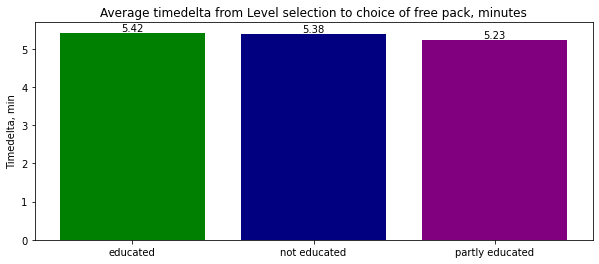

In [172]:
bar_data = level_to_purchase_df.groupby(
    by='user_type')['Timedelta_level_to_free_pack'].mean().round(2)

fig, axes = plt.subplots(figsize=(10,4))
bars=axes.bar(x = bar_data.index, height = bar_data, color=['green', 'navy','purple']);
axes.set_ylabel('Timedelta, min')
axes.set_title('Average timedelta from Level selection to choice of free pack, minutes')
for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  axes.text(label_x_pos, height, s=f'{height}', ha='center',
  va='bottom')

#### Комментарий к графику: Как видим из графика, разница во времени между выбором уровня сложности и выбору бесплатных вопросов не является значительной. Для пользователей, которые прошли обучение - это 5.42 минуты, для пользователей не завершивших обучение - 5.23 минуты и 5.38 для группы, не начинавшей обучение . То есть, все группы пользователей переходят от выбора уровня сложности к бесплатному пакету вопросов приблизительно за одинаковое время.

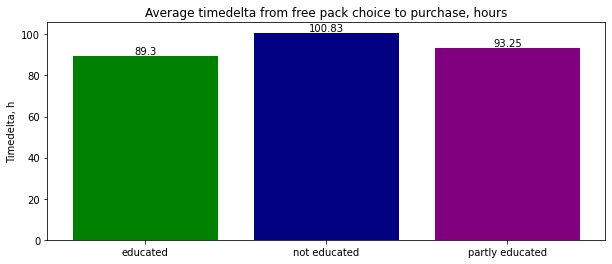

In [173]:
bar_data2 = level_to_purchase_df.groupby(
    by='user_type')['Timedelta_freepack_to_purchase'].mean().round(2)

fig, axes = plt.subplots(figsize=(10,4))

bars= axes.bar(x = bar_data2.index, height = bar_data2, color=['green', 'navy','purple']);
axes.set_ylabel('Timedelta, h')
axes.set_title('Average timedelta from free pack choice to purchase, hours')
for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  axes.text(label_x_pos, height, s=f'{height}', ha='center',
  va='bottom')

##### Комментарий к графику: Пользователям, которые не заканчивали обучение, необходимо гораздо больше времени для перехода к этапу покупки по сравнению с пользователями, которые проходили обучение.

### Вывод по Задаче 1: обучение практически не влияет на этап "выбор уровня сложности - выбор бесплатного пакета вопросов", но значительно сокращает период времени между выбором бесплатного пакета вопросов и покупкой.

### Задача 2: Проверка существования зависимости между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь

Text(0.5, 1.0, 'Split of users with purchases by user type')

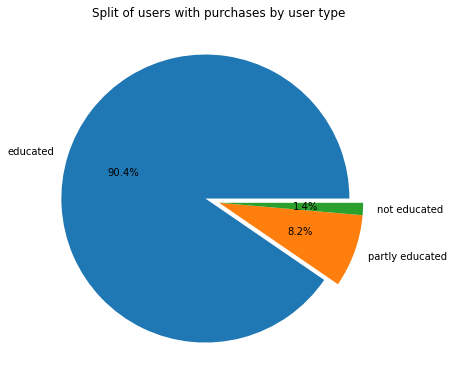

In [175]:
# creating pie chart to check who mostly does purchases
diagram_data = purchase_df1['user_type'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    diagram_data,
    labels=diagram_data.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0]
);
axes.set_title('Split of users with purchases by user type')

#### Комментарий: как мы видим из диаграммы, среди пользователей, которые совершают покупки со значительным перевесом преобладает группа, которая начала и закончила обучение (90.4%). Соответственно, можем считать, что само по себе обучение позитивно влияет на решение пользователя совершить покупку.

#### Необходимо проверить, как количество обучений влияет на оплату

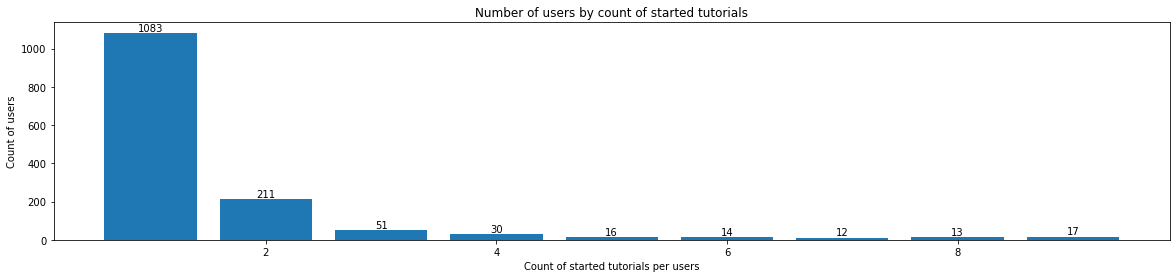

In [221]:
# calculating how many times each user started tutorial

mask1 = (total_df['user_type']=='educated')&(total_df['event_type']=='tutorial_start')                                        
educated_df=total_df[mask].groupby('user_id')['tutorial_id'].count()

# adding count of tutorials to Df with purchases

purchase_df2=purchase_df1.merge(educated_df, on='user_id', how='left')
purchase_df2=purchase_df2[purchase_df2['user_type']=='educated']

# crearting bar chart to see the number of users by count of tutorial start

bar_data2 = purchase_df2.groupby(
    by='tutorial_id_y')['user_id'].count()

fig, axes = plt.subplots(figsize=(20,4))

bars= axes.bar(x = bar_data2.index, height = bar_data2);
axes.set_ylabel('Count of users')
axes.set_xlabel('Count of started tutorials per users')
axes.set_title('Number of users by count of started tutorials')
for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  axes.text(label_x_pos, height, s=f'{height}', ha='center',
  va='bottom')

#### Комментарий: Среди пользователей, совершивших покупки, большую часть составляют пользователи, которые начинали обучение только один раз. Если пользователи начинали обучение более двух раз, то вероятность покупки снижается.

### Вывод по Задаче 1: В целом, обучение позитивно влияет на оплаты (покупки). Большинство пользователей делает оплату, если начинали обучение 1 раз. Небольшое количество пользователей совершало покупки, если они начинали обучение более двух раз.

### Задача 3: Определить, как часто пользователи начинают обучение после выбора уровня сложности

education_timing
after level choice     2792
before level choice    9894
no tutorial              98
Name: user_id, dtype: int64

Text(0.5, 1.0, 'Split of users by tutorial start type time')

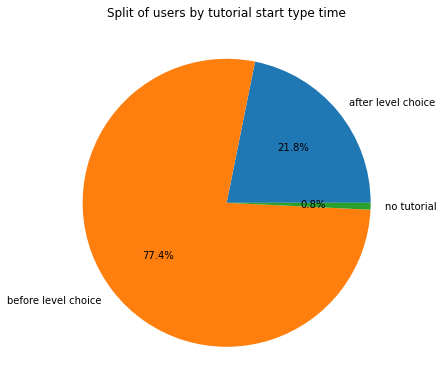

In [250]:
# creating a column with indicator whether tutorial was started before level choice or after
tutorial_start_df = total_df[total_df['event_type'] == "tutorial_start"]
tutorial_start_df = tutorial_start_df[["user_id","start_time"]].rename(columns={"start_time":"tutorial_choice_time"})
level_choice_turotial_df = level_choice_df.merge(tutorial_start_df, on ="user_id", how="left")
level_choice_turotial_df['Time_id']=(level_choice_turotial_df['tutorial_choice_time'] - level_choice_turotial_df['level_choice_time'])/pd.Timedelta('1 hour')
level_choice_turotial_df['education_timing'] = level_choice_turotial_df.apply(lambda x: 'after level choice' if x['Time_id'] > 0 else ('before level choice' if x['Time_id'] <0 else "no tutorial"), axis=1)

grouped = level_choice_turotial_df.groupby('education_timing')['user_id'].count()
display(grouped)

diagram_data = grouped
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    diagram_data,
    labels=diagram_data.index,
    autopct='%.1f%%',
    explode = [0, 0,0]
);
axes.set_title('Split of users by tutorial start type time')


### Вывод по Задаче 3: 77,4% пользователей предпочитают начать обучение до выбора уровня сложности. Среди тех, кто не начинает обучение сразу, большая часть пользователей (2792 чел., 21.8% от всех пользователей) возвращается к шагу "начать обучение". Лишь 98 чел (0.8% от всех пользователей) может двигаться в игре дальше без обучения. 
### То есть, процесс взаимодействия с игрой все же не совсем прозрачен без обучения

## Вывод по проекту: 
### Обучение является важным этапом игры: 
- Если пользователь прошел обучение, он, с большой долей вероятности, совершит покупку
- Если пользователь полностью прошел обучение, то он быстрее переходит ко покупке
- Без обучения игра не совсем понятна. Большая часть пользователей предпочитают проходить обучение. Возможно, следует сделать обучение обязательным этапом игры.